In [2]:
# **Imports**
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, TimeDistributed, SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator 
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from keras.callbacks import EarlyStopping

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Loading and Preparing the data

## Loading the Data 

In [188]:
local_path_target = '/Users/R/code/HaukeFock/predict_energy_generation/raw_data/hourly/energy_generation_data/df_deutschland.csv'

local_path_feature = "/Users/R/code/HaukeFock/predict_energy_generation/raw_data/hourly/features/hourly_globalradiation_df.csv"

data_target = pd.read_csv(local_path_target)
data_target['Date'] = pd.to_datetime(data_target.Date)
generation_df = data_target.groupby(by=data_target['Date']).sum()
solar_df = generation_df["Photovoltaics[MWh]"]


data_feature = pd.read_csv(local_path_feature)
data_feature['Date'] = pd.to_datetime(data_feature.Date)
data_feature = data_feature.set_index('Date')

# Preparing the Data




## Concatenating the Data

In [199]:
# making target and features dataframes compatible 
solar_df = solar_df['2020-01-01':]
solar_df.shape

(11664,)

In [197]:
complete_df = pd.concat([solar_df, data_feature], axis=1)
complete_df.shape

(11664, 120)

## Filtering the data with highly correlated timeseries Optional 

In [204]:
# get correlation between generated energy and stations
sorted_corr = complete_df.corr().abs().iloc[0].sort_values(ascending=False)
list_of_corr_060 = list(sorted_corr[sorted_corr >= 0.6].index)

# select most correlated stations(over 0.6)
filtered_df = complete_df.copy()[list_of_corr_060]
filtered_df.drop(columns=['Photovoltaics[MWh]'], inplace=True)
filtered_df.shape

(11664, 116)

## Scaling the Data

In [237]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(filtered_df)
X_scaled = pd.DataFrame(X_scaled, index=complete_df.index, columns=filtered_df.columns)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(pd.DataFrame(solar_df))
y_scaled = pd.Series(y_scaled.squeeze(), index=solar_df.index)

# Sarimax Model

## Train test split

In [343]:
# Train_Data
X_train = X_scaled.loc[:'2020-11-30']#.to_numpy()
y_train = y_scaled.loc[:'2020-11-30']#.to_numpy()
# validation Data
X_test = X_scaled.loc['2020-12-1':'2021-01-01']#.to_numpy()
y_test = y_scaled.loc['2020-12-1':'2021-01-01']#.to_numpy()

## Training and predicting with the Model

In [344]:
# orders of best model with exog wind speed and hourly data, non logarithmic data
bm_order = (0,1,0)
# could choose also 24  because sun always has a daily cycle
bm_seasonal_order = (0,0,0,24)

In [345]:
# The model
sarimax = SARIMAX(endog=y_train, exog=X_train, order=bm_order, seasonal_order=bm_seasonal_order ).fit()

/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/Users/R/.pyenv/versions/3.8.6/envs/predict_energy_generation/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [346]:
#Forecasting
y_pred = sarimax.forecast(y_test.shape[0], exog=X_test, alpha=0.05)

## Unscaling results

In [347]:
unscaled_y_train = pd.Series(scaler_y.inverse_transform(y_train.to_numpy().reshape(-1,1)).squeeze(), index=y_train.index)
unscaled_y_test = pd.Series(scaler_y.inverse_transform(y_test.to_numpy().reshape(-1,1)).squeeze(), index=y_test.index)
unscaled_y_pred = pd.Series(scaler_y.inverse_transform(y_pred.to_numpy().reshape(-1,1)).squeeze(), index=y_pred.index)

## MSE & Plot results

In [348]:
def plot_forecast(fc, train, test, upper=None, lower=None):
    is_confidence_int = isinstance(upper, np.ndarray) and isinstance(lower, np.ndarray)
    # Prepare plot series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(upper, index=test.index) if is_confidence_int else None
    upper_series = pd.Series(lower, index=test.index) if is_confidence_int else None

    # Plot
    plt.figure(figsize=(20,8), dpi=100)
    plt.plot(train, label='training', color='black')
    plt.plot(test, label='actual', color='black', ls='--')
    plt.plot(fc_series, label='forecast', color='orange')
    if is_confidence_int:
        plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Actuals')
    plt.legend(loc='upper left', fontsize=8);

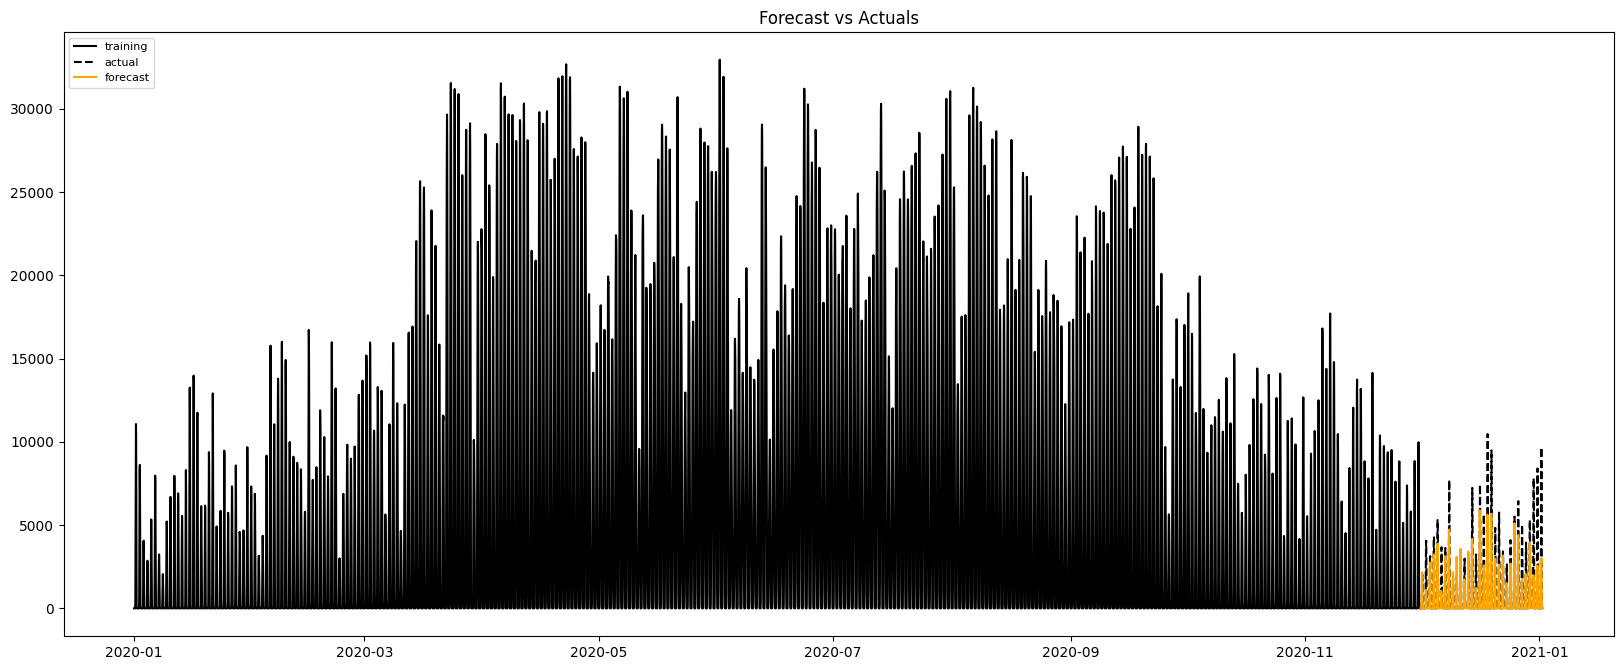

In [359]:
plot_forecast(unscaled_y_pred, unscaled_y_train, unscaled_y_test)

In [356]:
y_pred

Timestamp('2020-11-30 23:00:00')

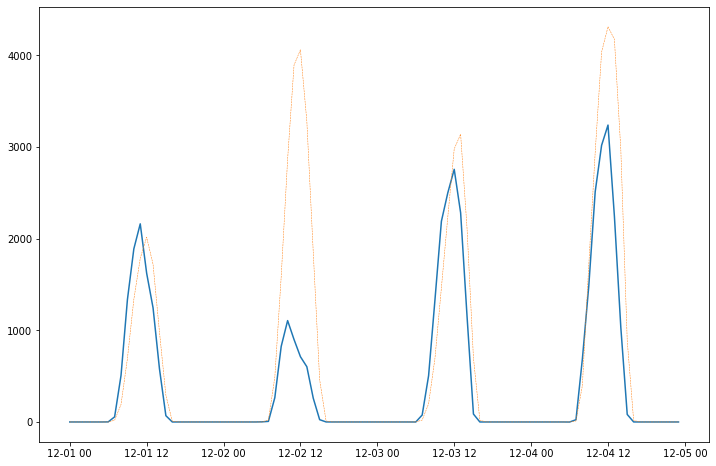

In [387]:
idx =24*4
plt.subplots(figsize=(12,8))
plt.plot(unscaled_y_pred.iloc[:idx])
plt.plot(unscaled_y_test.iloc[:idx], ls='--', lw=0.5)

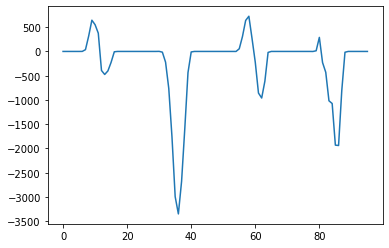

In [377]:
# plotting the residuals
plt.plot((unscaled_y_pred.iloc[:idx] - unscaled_y_test.iloc[:idx]).to_numpy().reshape(-1,1))

In [364]:
def mae(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(np.abs(y_true-y_pred))/(len(y_true))

def mse(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean((y_true-y_pred)**2)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    results = np.array([])
    for y_t, y_p in zip(y_true, y_pred):
        if y_t > 0:
            results = np.append(results, np.abs((y_t - y_p) / y_t))
    return results.mean()*100

In [400]:
# THE MAE
mae(unscaled_y_test, unscaled_y_pred)

465.8656976400746

In [396]:
mean_absolute_percentage_error(unscaled_y_test, unscaled_y_pred)

191.1565610855583

In [402]:
sarimax.save('/Users/R/code/HaukeFock/predict_energy_generation/predict_energy_generation/data/models/sun_model.pkl')

# Re-loading and testing model

In [98]:
from statsmodels.iolib.smpickle import load_pickle

sun_model = load_pickle('/Users/R/code/HaukeFock/predict_energy_generation/predict_energy_generation/data/models/sun_model.pkl')

In [116]:
scaler_y.inverse_transform(y_pred.reshape(1,-1)).shape

(1, 336)

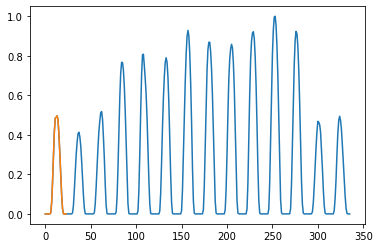

In [99]:
y_pred = sun_model.forecast(steps=len(testX2), exog=testX2, alpha=0.05)

plt.plot(y_pred)
plt.plot(testy2[:24])